# Imports

## Packages

In [60]:
# Used to split the data into training and testing
from sklearn.model_selection import train_test_split

# For printing
import pprint as pp

# Creates notmal probability density functions (PDFs)
import scipy.stats as st

# Used to assess the accuracy and AUC for our Naive Bayes Classifier
import sklearn.metrics as m

# Used to plot the ROC curve at the very end of this coding discussion
from plotnine import *

# General, frequently used packages
import pandas as pd
import numpy as np

## Data

In [2]:
# Imports the voter turnout data 
df = pd.read_csv("../turnout.csv")

In [3]:
# Display 5 random entries in the dataset
df.sample(5)

,id,age,educate,income,vote,white
1815,1816,41,9.0,4.6408,1,1
698,699,26,12.0,1.6049,0,1
1844,1845,79,16.0,1.9045,1,1
1853,1854,29,12.0,5.9469,1,1
539,540,63,12.0,0.9689,1,1


# Train-Test Split

We need to split our data before creating our model. For the purposes of this assignment, we will be splitting 80% of the data into a training set and the other 20% into a test set.

In [15]:
# Train-Test split where 80% is training data and 20% is testing
# Dropping "id" as it is not a predictive variable but a marker of the observation's placement in the dataset's order
train = df.sample(frac=.8).reset_index(drop=True).drop(["id"], axis=1)
test = df.drop(train.index).reset_index(drop=True).drop(["id"], axis=1)

# Sample the training data
train.sample(5)

,age,educate,income,vote,white
579,54,17.0,10.0376,1,1
999,52,10.0,3.4183,1,1
430,30,13.0,1.1046,0,1
496,52,12.0,4.6408,1,1
913,33,10.0,1.5788,1,0


# Naive Bayesian Classifier

First, we need to determine the class probabilities, i.e. how common is it for someone to vote and for someone to not vote in general.

In [17]:
# Saves the number of training observations as N
N = train.shape[0]

# Subset the data by whether an individual voted or not
vote1 = train.query("vote == 1")
vote0 = train.query("vote == 0")

# Calculate the probability for each class
pr_vote_1 = vote1.shape[0]/N
pr_vote_0 = vote0.shape[0]/N

# Print the class probabilities
print(
f"""
Pr(vote = 1): {pr_vote_1}
Pr(vote = 0): {pr_vote_0}
""")


Pr(vote = 1): 0.743125
Pr(vote = 0): 0.256875



An almost 3:1 split between voting and not voting. This means that if our model simply predicted that everyone votes, it would be 74% accurate.

In [31]:
# Creates a list where the zero index is the class probability that vote = 0, 
# and the first index is class probability that vote = 1
class_probs = [pr_vote_0, pr_vote_1]

## Binary Variable (White)

Below we will determine the probability that someone votes based on the only binary variable in our data, "white". From here we can develop conditional probabilities of the probability someone is white given whether or not they vote. These will be used when predicting class later on.

In [19]:
# Given vote == 1
w1_v1 = vote1.query("white == 1").shape[0]/vote1.shape[0]
w0_v1 = vote1.query("white == 0").shape[0]/vote1.shape[0]

# Given vote == 0
w1_v0 = vote0.query("white == 1").shape[0]/vote0.shape[0]
w0_v0 = vote0.query("white == 0").shape[0]/vote0.shape[0]

# Print the conditional probabilities for "white"
print(
f"""
Pr(white = 1 |vote = 1): {w1_v1}
Pr(white = 0 |vote = 1): {w0_v1}
Pr(white = 1 |vote = 0): {w1_v0}
Pr(white = 0 |vote = 0): {w0_v0}
""")


Pr(white = 1 |vote = 1): 0.8713204373423045
Pr(white = 0 |vote = 1): 0.12867956265769553
Pr(white = 1 |vote = 0): 0.7883211678832117
Pr(white = 0 |vote = 0): 0.2116788321167883



Shown above are the conditional probabilities which will be used in our Naive Bayes Classifier. It appears that the probability of white is higher given that one does or does not vote, albeit slightly higher given one votes. This is important, as there are likely far more white people in our dataset than non-white people, which could impact our results.

In [32]:
# Creates the conditional probabilities variable
# The first number in the tuple is whether someone is white, 
# and the second variable is whether they vote
cond_probs = {('white', 0, 0): w0_v0,
 ('white', 0, 1): w0_v1,
 ('white', 1, 0): w1_v0,
 ('white', 1, 1): w1_v1
}

## Continuous Variables

Finally, we will determine the distributions for each continuous variable given whether or not someone votes. These will be used to assign probabilities based on a normal distribution. An example of how this information will be used to construct probabilities is coded at the end of this section.

In [22]:
# Collect the mean and standard dev. of each conditional distribution
dist_locs = \
{("age",1):{'mean':vote1.age.mean(),'sd':vote1.age.std()},
 ("age",0):{'mean':vote0.age.mean(),'sd':vote0.age.std()},
 ("educate",1):{'mean':vote1.educate.mean(),'sd':vote1.educate.std()},
 ("educate",0):{'mean':vote0.educate.mean(),'sd':vote0.educate.std()},
 ("income",1):{'mean':vote1.income.mean(),'sd':vote1.income.std()},
 ("income",0):{'mean':vote0.income.mean(),'sd':vote0.income.std()},
}

# Print the components of the distributions
pp.pprint(dist_locs)

{('age', 0): {'mean': 43.17031630170316, 'sd': 19.237671241024938},
 ('age', 1): {'mean': 46.42977291841884, 'sd': 16.91112105048275},
 ('educate', 0): {'mean': 10.643552311435522, 'sd': 3.224914600353615},
 ('educate', 1): {'mean': 12.521026072329688, 'sd': 3.337935503331938},
 ('income', 0): {'mean': 2.8039654501216544, 'sd': 2.242633271407277},
 ('income', 1): {'mean': 4.284949789739277, 'sd': 2.9591047035905684}}


Example: The mean age of someone who votes is 46, and the standard deviation is 17. Conversely, the mean age of someone who does NOT vote is 43, with a standard deviation of 19. We can then take the age of an individual, say 47, and determine the likelihood that observation would be found in either distribution. The likelihood this person is a voter or non-voter is calculated below using code.

In [56]:
pr_non_voter = st.norm(dist_locs[("age",0)]['mean'],
                       dist_locs[("age",0)]['sd']).pdf(47)
pr_voter = st.norm(dist_locs[("age",1)]['mean'],
                   dist_locs[("age",1)]['sd']).pdf(47)

In [59]:
print("Probability a 47 year old would vote: " + str(round(pr_voter*100,2)))

Probability a 47 year old would vote: 2.36


In [58]:
print("Probability a 47 year old would vote: " + str(round(pr_non_voter*100,2)))

Probability a 47 year old would vote: 2.03


Therefore we assume that this person would vote, based only on their age.

# Model

With all of our probabilities stored, we can begin the process of predicting whether someone votes or not.

## Predictions

Predictions will be made using this following Naive Bayes Classifier equation, which makes the important assumption that all features are independent of one another.

$$Pr(class | data) = Pr( x_1| class)\times Pr( x_2| class) \times \dots \times  Pr(class)$$

In practice, we will take each observation, determine the probability for either class, and choose the class with the highest probability. This entails calculating the probability of finding each feature given a particular class, calculating the product of these values, and then multiplying by the likelihood of finding each class.

In [36]:
# Predicts the class of a binary variable based on both binary and continuous variables
def predict(data, class_probs, cond_probs, dist_locs, binaries):
    '''
    This function takes in training data, without the outcome variable,
    and makes a prediction as to the outcome variable
    
    Inputs:
    data - Training data as a pandas dataframe, not including the outcome variable
    class_probs - A dictionary including the probability that the training data is either class
    cond_probs - A dictionary including the probability that the outcome variable is either class
                 given a binary variable's value
    dist_locs - A dictionary including the probability that the outcome variable is either class
                given a continous variable's value
    binaries - A list of which variables are binary, thereby allowing us to adjust
               how each probability is calculated
    '''
    
    # Creates a list in which to store predictions
    store_preds = []
    
    # Iterates over each row in the data
    for i,row in data.iterrows():
        
        # Initializes the probabilities of each binary class to 1
        pr_1 = 1; pr_0 = 1
        
        # Iterates over each variable in the given row
        for j in range(0,len(row.index)):
            
                # Determines whether the variable is a binary variable or not
                if row.index[j] in binaries:
                    
                    # Multiplies the probability for each class by the probability of 
                    # finding a particular value of this feature given the class label
                    pr_0 *= cond_probs[(row.index[j],row.values[j],0)]
                    pr_1 *= cond_probs[(row.index[j],row.values[j],1)] 
                else:
                    
                    # Multiplies the probability for each class by the probability of 
                    # finding a particular value of this feature given the class label
                    pr_0 *= st.norm(dist_locs[(row.index[j],0)]['mean'],
                            dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
                    pr_1 *= st.norm(dist_locs[(row.index[j],1)]['mean'], 
                            dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])
        
        # Mutliplies by the probability of finding each class in general
        pr_0 *= class_probs[0]
        pr_1 *= class_probs[1]
                    
        # Picks the highest probability between either class
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1   
            
        # Stores the probabilities for each class and prediction as a list, 
        # then appends to the list of predictions            
        store_preds.append([pr_0,pr_1,class_pred])
        
    # Returns the probabilities and predictions as a dataframe
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

In [28]:
# Sets up a list of which variables are binaries
binaries = ["white"]

In [38]:
# Run predictions on the training data
df_predictions = predict(train.drop("vote", axis = 1), class_probs, cond_probs, dist_locs, binaries)

In [44]:
# View a sample of the predictions we have generated
df_predictions.sample(10)

,pr_0,pr_1,pred
530,0.000004,0.000010,1
962,0.000006,0.000110,1
42,0.000029,0.000198,1
1592,0.000019,0.000016,0
1187,0.000004,0.000016,1
336,0.000010,0.000021,1
1180,0.000044,0.000106,1
1103,0.000076,0.000237,1
665,0.000075,0.000127,1
1447,0.000007,0.000004,0


It appears our model "works" in the roughest sense - it makes predictons. Now we'll asses how well our model works.

## Performance

We'll be assessing the accuracy and AUC of our model. The accuracy is a simply measure of how often our model predicts the right class. The AUC value is 

In [47]:
# Put the data into a format which sklearn can interpret
train_y = train['vote']
train_x = train.drop(["vote"], axis=1)
test_y = test['vote']
test_x = test.drop(["vote"], axis=1)

In [53]:
# Runs the model on the testing data
df_predictions_test = predict(test.drop("vote", axis = 1), class_probs, cond_probs, dist_locs, binaries)

# Extracts the predictions from our results
y_pred = df_predictions_test["pred"]

In [54]:
# Out-of-sample performance 
m.accuracy_score(test_y, y_pred)

0.71

This accuracy is not terrible but also not great. Of all predictions, 71% were correct. This sounds good, but keep in mind that simply predicting that everyone voted would return an accuracy of 74%. By that measure then, we should simply predict that everyone votes instead of using this model.

Note though that always predicting that someone votes would make our false positive rate 100%. If we are hoping to find those who do not vote as opposed to simply predicting accurately, then always predicting that someone voted would make for a terrible model.

In [55]:
# Area under the ROC curve
m.roc_auc_score(test_y,y_pred)

0.569047619047619

This is a pretty poor AUC. At 0.57, our model only barely predicts better than using a coin flip (AUC = 0.50).

In [65]:
probs = df_predictions_test[["pr_0", "pr_1"]].rename({"pr_0":0.0, "pr_1":1.0}, axis = 'columns')
probs.sample(5)

,0.0,1.0
113,0.000062,0.000234
114,0.000018,0.000077
268,0.000001,0.000033
96,0.000011,0.000021
166,0.000020,0.000024


In [66]:
# Generate the False Positive Rate and True Positive Rate Given different thresholds
fpr, tpr, thresholds = m.roc_curve(test_y, probs[1])

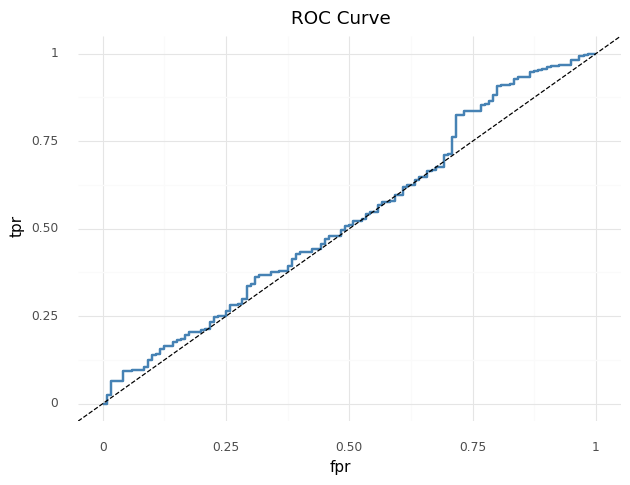

<ggplot: (108346074227)>

In [67]:
# Plot the ROC Curve
( 
    ggplot(pd.DataFrame(dict(fpr=fpr,tpr=tpr)),
           aes(x="fpr",y="tpr")) +
    geom_path(color="steelblue",size=1) +
    geom_abline(intercept=0,slope=1,linetype="dashed") +
    theme_minimal() +
    labs(title="ROC Curve") +
    theme(figure_size=(7,5))
)

The above visualization shows just how closely our predictions are to random choices. The $45^o$ line shows what random choices would return. Our line skims just barely along the top of the $45^o$ line, even dipping below from time to time.

# Summary

Accuracy: 0.71 <br>
AUC: 0.57 <br>

Our model predicts moderately better than chance, but not by much, as our AUC is only 0.57. Our model's accuracy is 0.71, meaning that our model predicts correctly the class of an observation 71% of the time. This accuracy is slightly lower than the accuracy from a model which returns only that an individual has voted, as 74% of the people in this data voted. 

As one would likely be using this model to find those least likely to vote, using a model which only predicts that people vote would be irresponsible. While this model is not perfect, it is better than both chance in terms of AUC and a constant model (only predicting someone voted) in terms of utility.